In [1]:
#Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import os
import shutil
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

#Importing libraries needed for the modeling and training
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, Callback , ModelCheckpoint
from tensorflow.keras.metrics import Accuracy,binary_crossentropy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pickle
# Load preprocessed datasets from pickle file
with open('/content/drive/MyDrive/preprocessed_data.pkl', 'rb') as f:
    training_images, training_labels, val_images, val_labels, test_images, test_labels = pickle.load(f)


In [4]:
datagen = ImageDataGenerator(
     rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

In [5]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, BatchNormalization, Dense, Dropout
from keras.layers import GlobalAveragePooling2D, Dense

# Load InceptionV3 base model without top layers and with pre-trained ImageNet weights
base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Create a sequential model and add the base model to it
model = Sequential()
model.add(base_model)

# Add custom top layers
model.add(Flatten())
model.add(BatchNormalization())

# Add dense layer with 64 units and ReLU activation
model.add(Dense(64, activation='relu'))
# Add dropout for regularization
model.add(Dropout(0.4))  # Increased dropout rate to 0.4

# Add final dense layer for binary classification with sigmoid activation
model.add(Dense(1, activation='sigmoid'))

# Print model summary
model.summary()
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

87910968/87910968 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 batch_normalization_94 (Ba  (None, 51200)             204800    
 tchNormalization)                                               
                                                                 
 dense (Dense)               (None, 64)                3276864   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65

In [6]:
#Setting the learning rate to reduce gradually over the training period
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.0001,
  decay_steps=20*50,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

In [10]:
#Compiling the model
model.compile(loss='binary_crossentropy', optimizer=get_optimizer(), metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=10)
checkpoint = ModelCheckpoint("./Best_model/.keras", save_best_only=True)

In [11]:
#Fitted the model on the training and and validation dataset using the image augmentor for 200 epochs
history = model.fit(datagen.flow(training_images, training_labels, batch_size = 32),
                                     validation_data=datagen.flow(val_images, val_labels),
                                     epochs=70,
                                     callbacks=[early_stop,checkpoint],
                                     verbose = 1)

Epoch 1/70
159/159 [==============================] - 85s 508ms/step - loss: 0.5779 - accuracy: 0.7014 - val_loss: 0.5372 - val_accuracy: 0.7322
Epoch 2/70
159/159 [==============================] - 78s 491ms/step - loss: 0.5637 - accuracy: 0.7084 - val_loss: 0.5454 - val_accuracy: 0.7235
Epoch 3/70
159/159 [==============================] - 78s 488ms/step - loss: 0.5614 - accuracy: 0.7103 - val_loss: 0.5399 - val_accuracy: 0.7306
Epoch 4/70
159/159 [==============================] - 79s 496ms/step - loss: 0.5606 - accuracy: 0.7133 - val_loss: 0.5337 - val_accuracy: 0.7243
Epoch 5/70
159/159 [==============================] - 77s 485ms/step - loss: 0.5595 - accuracy: 0.7169 - val_loss: 0.5371 - val_accuracy: 0.7235
Epoch 6/70
159/159 [==============================] - 77s 483ms/step - loss: 0.5581 - accuracy: 0.7111 - val_loss: 0.5342 - val_accuracy: 0.7283
Epoch 7/70
159/159 [==============================] - 79s 500ms/step - loss: 0.5414 - accuracy: 0.7196 - val_loss: 0.5168 - val_ac

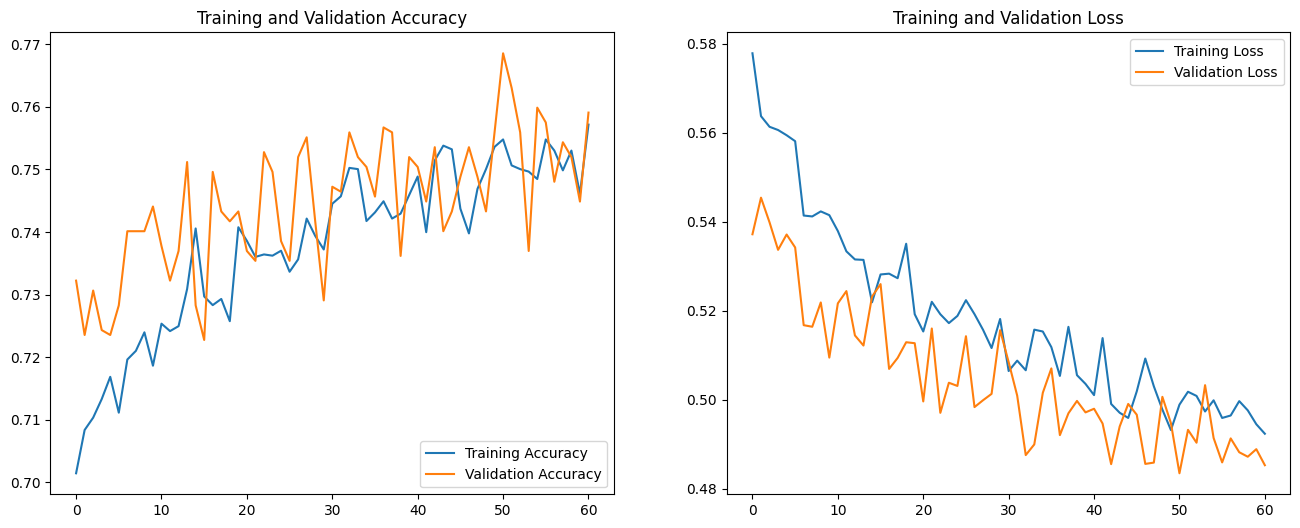

In [12]:
#Plotting the model results

#Getting the accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

#Getting the losses
loss = history.history['loss']
val_loss = history.history['val_loss']

#No of epochs it trained
epochs_range = history.epoch

#Plotting Training and Validation accuracy
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [25]:
v3_y_pred = model.predict(test_images)

50/50 [==============================] - 10s 195ms/step


In [26]:
print(v3_y_pred)

[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]


In [27]:
#Round up model prediction to 0 and 1 and convert result to an array
rounded = [float(np.round(x)) for x in v3_y_pred]
rounded_v3 = np.asarray(rounded).astype(int)
print(rounded_v3)

[1 1 1 ... 1 1 1]


<ipython-input-27-00e6732a8a61>:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rounded = [float(np.round(x)) for x in v3_y_pred]


[[   0  482]
 [   0 1100]]


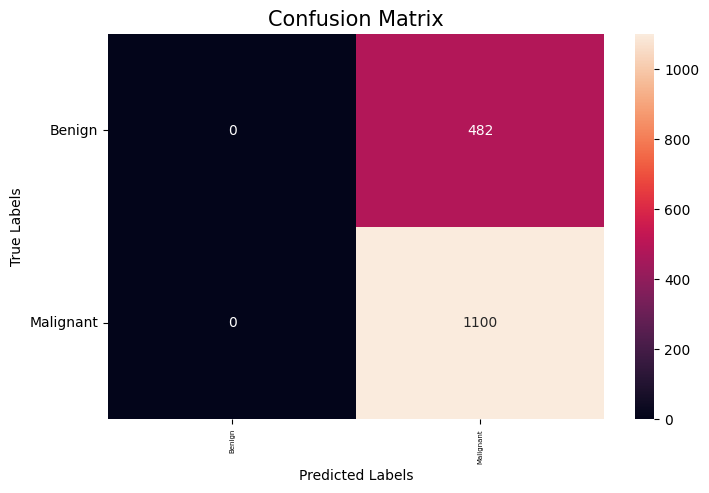

In [28]:
#Confusion matrix
cm = confusion_matrix(test_labels, rounded_v3)
print(cm)

import seaborn as sns

#Setting the labels
labels = ['Benign', 'Malignant']

#Plot the Confusion matrix graph
fig= plt.figure(figsize=(8, 5))
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g')
ax.set_xlabel('Predicted Labels', fontsize=10)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(labels, fontsize = 5)
ax.xaxis.tick_bottom()

ax.set_ylabel('True Labels', fontsize=10)
ax.yaxis.set_ticklabels(labels, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Confusion Matrix', fontsize=15)

plt.savefig('ConMat24.png')
plt.show()

In [29]:
#Classification report
print(classification_report(test_labels, rounded_v3))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       482
           1       0.70      1.00      0.82      1100

    accuracy                           0.70      1582
   macro avg       0.35      0.50      0.41      1582
weighted avg       0.48      0.70      0.57      1582



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
#Accuracy
accuracy = accuracy_score(test_labels, rounded_v3)
print('Accuracy: %f' % accuracy)

Accuracy: 0.695322


In [33]:
#Precision
precision = precision_score(test_labels, rounded_v3)
print('Precision: %f' % precision)

Precision: 0.695322


In [34]:
# Recall
recall = recall_score(test_labels, rounded_v3, pos_label=1)
print('Recall: %f' % recall)

Recall: 1.000000


In [35]:
#Specificity
specificity = recall_score(test_labels, rounded_v3, pos_label=0)
print('Specificity: %f' % specificity)

Specificity: 0.000000


In [36]:
#F1-score
F1_score = f1_score(test_labels, rounded_v3)
print('F1_score: %f' % F1_score)

F1_score: 0.820283


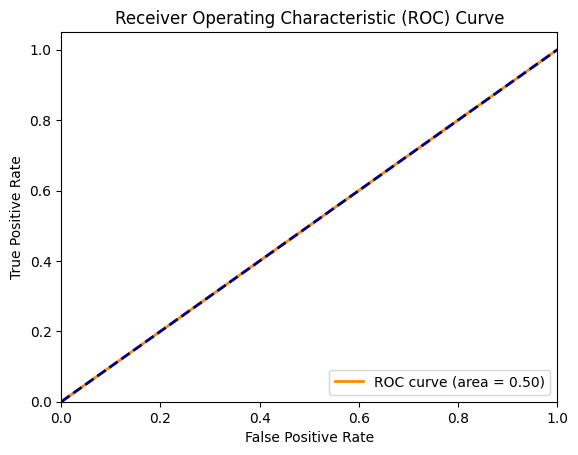

In [37]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, v3_y_pred)

# Calculate the area under the ROC curve
roc_auc = roc_auc_score(test_labels, v3_y_pred)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [38]:
# Getting the accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Final accuracy
final_accuracy = acc[-1]
final_val_accuracy = val_acc[-1]

print("Final Training Accuracy:", final_accuracy)
print("Final Validation Accuracy:", final_val_accuracy)


Final Training Accuracy: 0.7571626305580139
Final Validation Accuracy: 0.7590837478637695


In [ ]:
#Save the model
model.save("/content/drive/MyDrive/Disertatie/InceptionV3_Model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
